<a href="https://colab.research.google.com/github/hannahscha/MLproject/blob/main/Making_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model

In [1]:
# @title installing ibraries

# Installing necessary libraries
!pip install imbalanced-learn
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.0 MB/s eta 0:00:00


In [2]:
# @title importing libraries
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
sns.set_theme(context='notebook', palette='pastel', style='whitegrid')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# @title reading and understanding the data

# Load the dataset
df = pd.read_csv('/content/student-mat.csv')

# Overview of the dataset
print("Dataset Shape:", df.shape)
df.info()

# Visualize missing values
print("Missing Values:\n", df.isnull().sum())

# Replace missing values with the mean for numeric columns
for col in df.select_dtypes(include=np.number):
    df[col] = df[col].fillna(df[col].mean())
print("Missing Values After Replacement:\n", df.isnull().sum())



Dataset Shape: (395, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null 

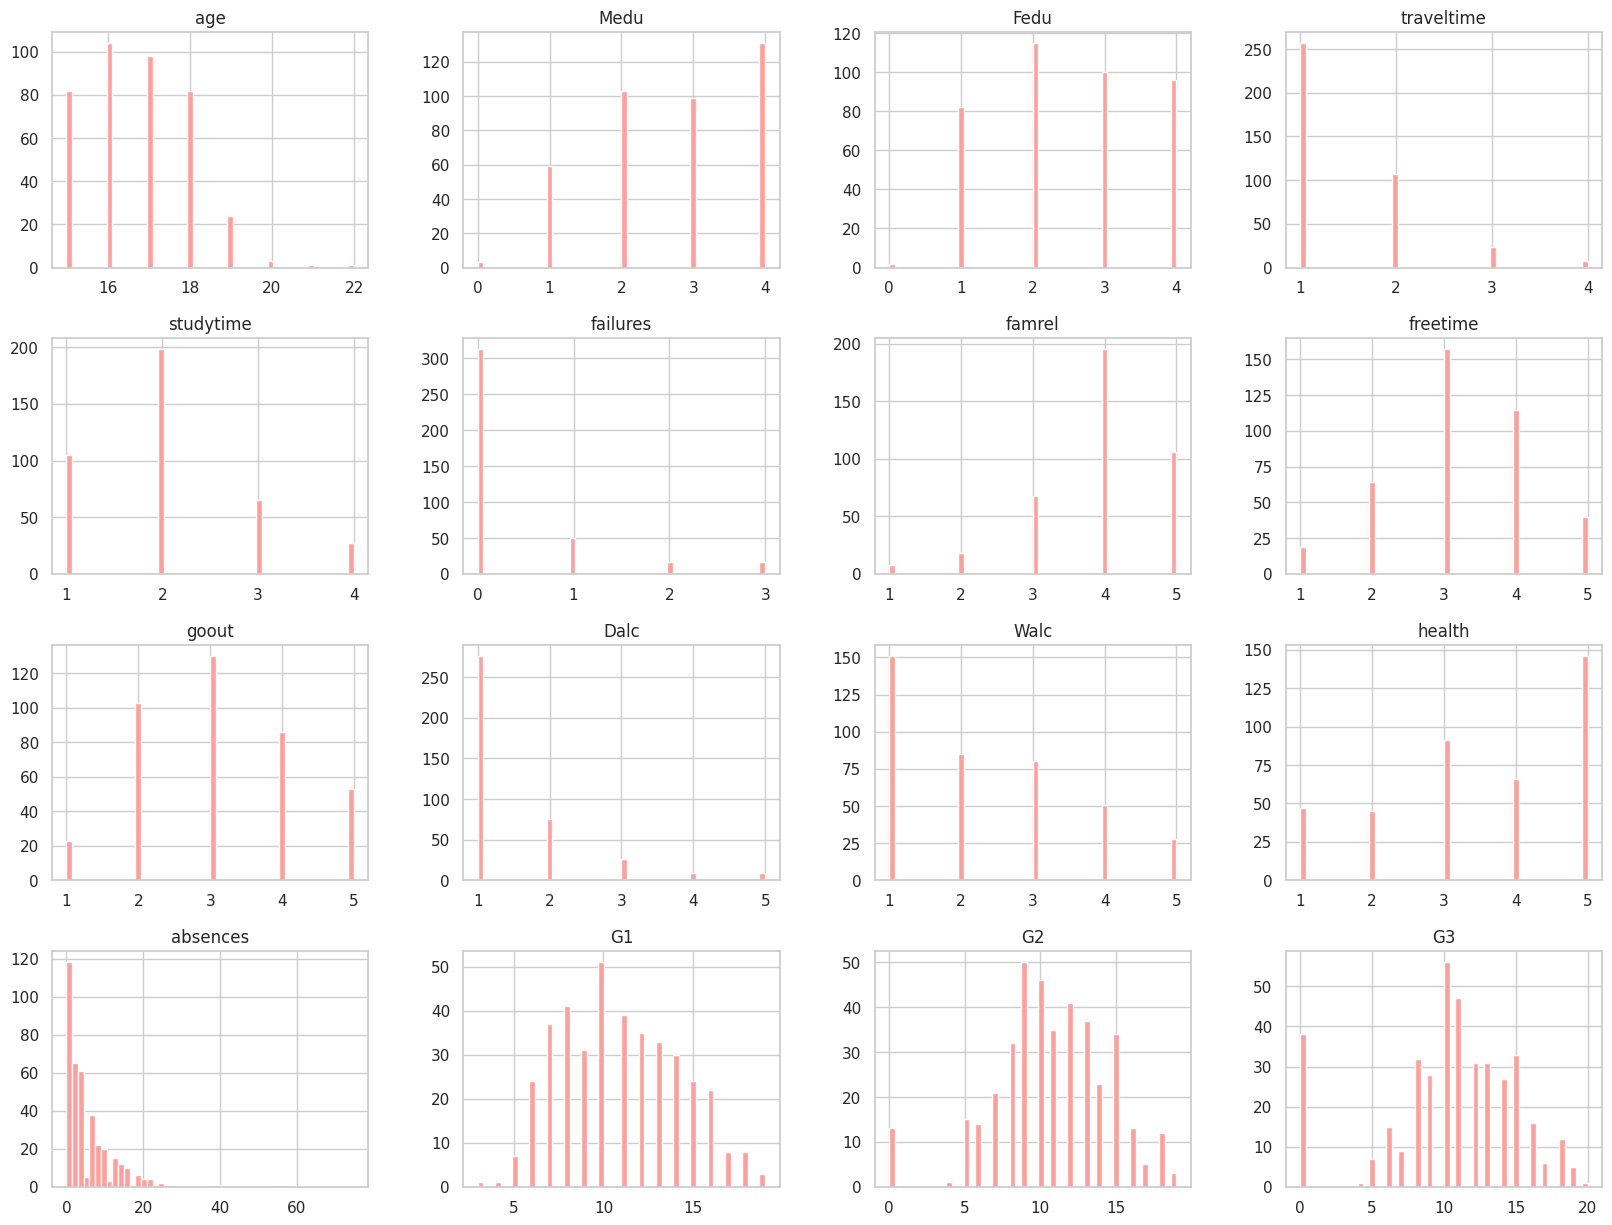

In [4]:
# @title initial visualizations

# Distribution of numeric variables
df.hist(bins=50, figsize=(20, 15), color='r')
plt.show()

# Grade distributions for G1, G2, and G3
import plotly.express as px
fig = px.histogram(df, x=["G1", "G2", "G3"], barmode='stack', labels={"variable": "Semester", "value": "Grades"}, title="Distribution of Grades")
fig.show()


In [5]:
# @title preprocessing

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert binary columns to integers
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
for col in binary_cols:
    unique_vals = df[col].unique()
    mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
    df[col] = df[col].map(mapping)

# Drop G1 and G2 to prevent information leakage
df.drop(['G1', 'G2'], axis=1, inplace=True)

# Define grade_status as the target variable
df['grade_status'] = df['G3'].apply(lambda x: 0 if x < 12 else 1)


Revised Correlations with grade_status:
 grade_status         1.000000
G3                   0.730890
schoolsup_yes        0.182913
Medu                 0.181728
Fedu                 0.144512
Mjob_health          0.129482
sex_M                0.116555
reason_reputation    0.092472
famsize_LE3          0.070946
internet_yes         0.069929
studytime            0.069135
Mjob_services        0.055768
reason_other         0.022095
freetime             0.019907
activities_yes       0.016108
Fjob_health          0.015246
famrel               0.011626
Mjob_teacher         0.003093
guardian_mother     -0.000395
paid_yes            -0.002406
Pstatus_T           -0.003119
nursery_yes         -0.015556
Fjob_services       -0.017452
romantic_yes        -0.023315
health              -0.043807
Fjob_other          -0.051698
reason_home         -0.054164
famsup_yes          -0.055478
school_MS           -0.062031
Mjob_other          -0.062610
Dalc                -0.063204
guardian_other      -0.077796

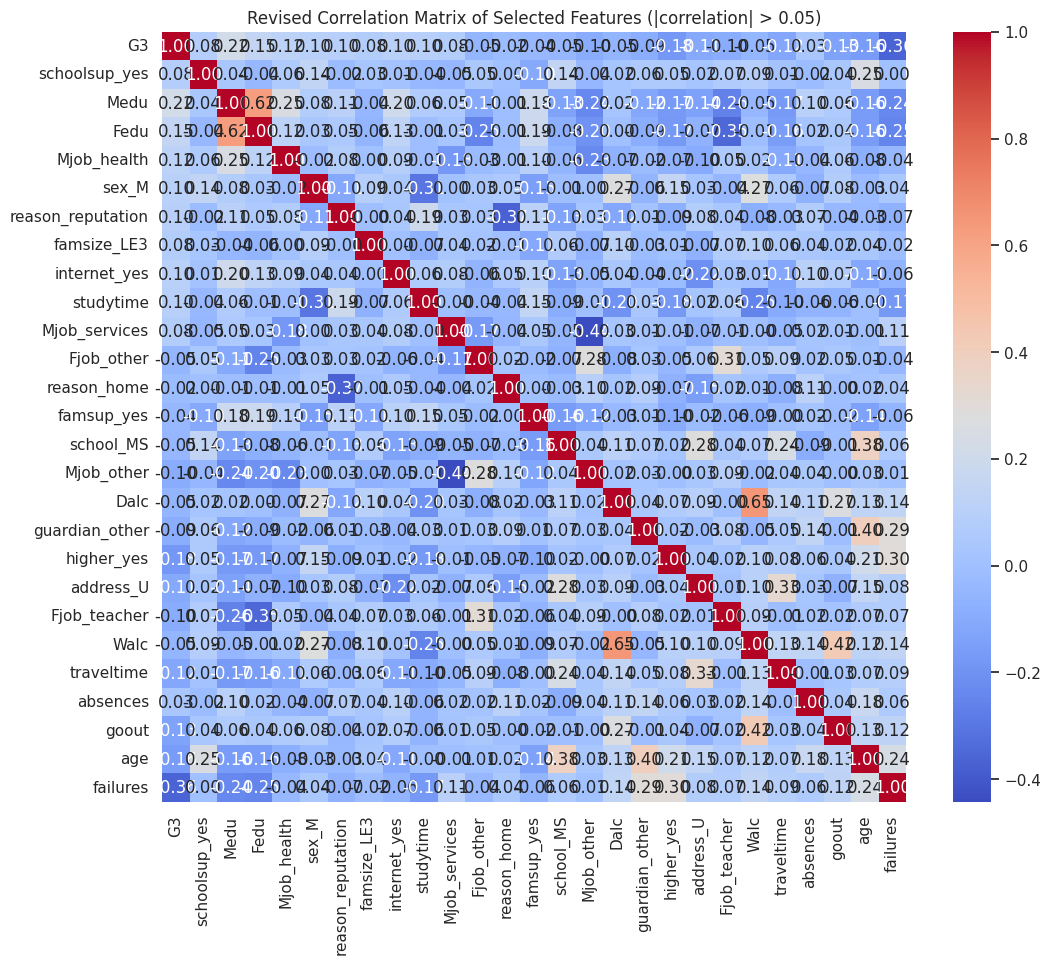

In [6]:
# @title Correlation Matrix Analysis with Magnitude Threshold

# Recalculate correlations with 'grade_status'
corr_matrix = df.corr()
corr_with_grade_status = corr_matrix['grade_status'].sort_values(ascending=False)
print("Revised Correlations with grade_status:\n", corr_with_grade_status)

# Use absolute magnitude threshold for feature selection
threshold = 0.05
selected_features_corr = corr_with_grade_status[abs(corr_with_grade_status) > threshold].index

# Ensure 'grade_status' is not included as a feature
selected_features_corr = selected_features_corr.drop('grade_status', errors='ignore')
print("Selected Features Based on |Correlation| > 0.05:\n", selected_features_corr)

# Visualize the correlation matrix of the selected features
plt.figure(figsize=(12, 10))
sns.heatmap(df[selected_features_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Revised Correlation Matrix of Selected Features (|correlation| > 0.05)')
plt.show()

# Define X (features) and y (target variable)
X = df[selected_features_corr].drop(columns=['G3'], errors='ignore')  # Drop G3 to prevent data leakage
y = df['G3']  # Using G3 as the regression target


In [7]:
# @title Splitting and Balancing Data

# Train-Validation-Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Standardize features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Verify data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (237, 26), y_train shape: (237,)
X_val shape: (79, 26), y_val shape: (79,)
X_test shape: (79, 26), y_test shape: (79,)


In [8]:
# @title Feature Engineering

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Fit Logistic Regression as a baseline
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)

# Evaluate on validation and test sets
y_val_pred_baseline = logreg.predict(X_val_scaled)
y_test_pred_baseline = logreg.predict(X_test_scaled)

# Baseline metrics
baseline_metrics = {
    "Validation Accuracy": accuracy_score(y_val, y_val_pred_baseline),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_baseline),
}
print("Baseline Metrics with Logistic Regression:", baseline_metrics)


Baseline Metrics with Logistic Regression: {'Validation Accuracy': 0.189873417721519, 'Test Accuracy': 0.10126582278481013}


In [9]:
# @title random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

# Define models and hyperparameter grids
models = {
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 20, 30],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5]
    }),
    "Decision Tree": (DecisionTreeRegressor(random_state=42), {
        'max_depth': [10, 20, 30],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }),
    "Ridge Regression": (Ridge(), {
        'alpha': [0.1, 1, 10]
    }),
    "K-Nearest Neighbors": (KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    })
}

results_random = []

for name, (model, param_grid) in models.items():
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='r2',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_val_pred = best_model.predict(X_val_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    # Metrics
    metrics = {
        "Model": name,
        "Search Type": "Randomized",
        "Best Params": search.best_params_,
        "Train R²": r2_score(y_train, y_train_pred),
        "Validation R²": r2_score(y_val, y_val_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    }
    results_random.append(metrics)

results_random_df = pd.DataFrame(results_random)
results_random_df.to_csv('model_results_random_search.csv', index=False)
print("Randomized Search Results Saved to model_results_random_search.csv")

# Display results
print(f"{metrics['Search Type']} Search Results:")
print(results_random_df)

# Alternatively, display in a notebook-friendly format
from IPython.display import display
display(results_random_df)


Randomized Search Results Saved to model_results_random_search.csv
Randomized Search Results:
                 Model Search Type  \
0        Random Forest  Randomized   
1    Gradient Boosting  Randomized   
2        Decision Tree  Randomized   
3     Ridge Regression  Randomized   
4  K-Nearest Neighbors  Randomized   

                                         Best Params  Train R²  Validation R²  \
0  {'n_estimators': 50, 'min_samples_split': 10, ...  0.664959       0.294465   
1  {'n_estimators': 50, 'max_depth': 3, 'learning...  0.689674       0.236225   
2  {'min_samples_split': 10, 'min_samples_leaf': ...  0.642167       0.061594   
3                                      {'alpha': 10}  0.284705       0.014077   
4  {'weights': 'distance', 'n_neighbors': 7, 'met...  1.000000       0.088127   

    Test R²     Train MAE  Validation MAE  Test MAE    Train RMSE  \
0  0.341220  2.015988e+00        2.690743  2.993121  2.718807e+00   
1  0.266439  2.024871e+00        2.829562  3.096096 

,Model,Search Type,Best Params,Train R²,Validation R²,Test R²,Train MAE,Validation MAE,Test MAE,Train RMSE,Validation RMSE,Test RMSE
0,Random Forest,Randomized,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.664959,0.294465,0.341220,2.015988e+00,2.690743,2.993121,2.718807e+00,3.525286,3.675366
1,Gradient Boosting,Randomized,"{'n_estimators': 50, 'max_depth': 3, 'learning...",0.689674,0.236225,0.266439,2.024871e+00,2.829562,3.096096,2.616609e+00,3.667903,3.878363
2,Decision Tree,Randomized,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.642167,0.061594,0.105773,2.045620e+00,3.127522,3.405430,2.809766e+00,4.065654,4.282075
3,Ridge Regression,Randomized,{'alpha': 10},0.284705,0.014077,0.211410,3.016749e+00,3.047099,3.146286,3.972577e+00,4.167315,4.021203
4,K-Nearest Neighbors,Randomized,"{'weights': 'distance', 'n_neighbors': 7, 'met...",1.000000,0.088127,0.016097,6.525629e-08,2.911262,3.732557,2.519842e-07,4.007764,4.491656


In [10]:
# @title grid search

from sklearn.model_selection import GridSearchCV

results_grid = []

for name, (model, param_grid) in models.items():
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_val_pred = best_model.predict(X_val_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    # Metrics
    metrics = {
        "Model": name,
        "Search Type": "Grid",
        "Best Params": search.best_params_,
        "Train R²": r2_score(y_train, y_train_pred),
        "Validation R²": r2_score(y_val, y_val_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    }
    results_grid.append(metrics)

results_grid_df = pd.DataFrame(results_grid)
results_grid_df.to_csv('model_results_grid_search.csv', index=False)
print("Grid Search Results Saved to model_results_grid_search.csv")

# Display results
print(f"{metrics['Search Type']} Search Results:")
print(results_grid_df)

# Alternatively, display in a notebook-friendly format
from IPython.display import display
display(results_grid_df)


Grid Search Results Saved to model_results_grid_search.csv
Grid Search Results:
                 Model Search Type  \
0        Random Forest        Grid   
1    Gradient Boosting        Grid   
2        Decision Tree        Grid   
3     Ridge Regression        Grid   
4  K-Nearest Neighbors        Grid   

                                         Best Params  Train R²  Validation R²  \
0  {'max_depth': 20, 'min_samples_leaf': 2, 'min_...  0.664959       0.294465   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  0.689674       0.236225   
2  {'max_depth': 10, 'min_samples_leaf': 4, 'min_...  0.642167       0.061594   
3                                      {'alpha': 10}  0.284705       0.014077   
4  {'metric': 'euclidean', 'n_neighbors': 7, 'wei...  1.000000       0.088127   

    Test R²     Train MAE  Validation MAE  Test MAE    Train RMSE  \
0  0.341220  2.015988e+00        2.690743  2.993121  2.718807e+00   
1  0.266439  2.024871e+00        2.829562  3.096096  2.616609e+00 

,Model,Search Type,Best Params,Train R²,Validation R²,Test R²,Train MAE,Validation MAE,Test MAE,Train RMSE,Validation RMSE,Test RMSE
0,Random Forest,Grid,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.664959,0.294465,0.341220,2.015988e+00,2.690743,2.993121,2.718807e+00,3.525286,3.675366
1,Gradient Boosting,Grid,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.689674,0.236225,0.266439,2.024871e+00,2.829562,3.096096,2.616609e+00,3.667903,3.878363
2,Decision Tree,Grid,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.642167,0.061594,0.105773,2.045620e+00,3.127522,3.405430,2.809766e+00,4.065654,4.282075
3,Ridge Regression,Grid,{'alpha': 10},0.284705,0.014077,0.211410,3.016749e+00,3.047099,3.146286,3.972577e+00,4.167315,4.021203
4,K-Nearest Neighbors,Grid,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",1.000000,0.088127,0.016097,6.525629e-08,2.911262,3.732557,2.519842e-07,4.007764,4.491656


In [11]:
# @title baysian search

from skopt import BayesSearchCV

results_bayes = []

for name, (model, param_grid) in models.items():
    search = BayesSearchCV(
        estimator=model,
        search_spaces=param_grid,
        scoring='r2',
        cv=5,
        n_iter=20,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_val_pred = best_model.predict(X_val_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    # Metrics
    metrics = {
        "Model": name,
        "Search Type": "Bayesian",
        "Best Params": search.best_params_,
        "Train R²": r2_score(y_train, y_train_pred),
        "Validation R²": r2_score(y_val, y_val_pred),
        "Test R²": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    }
    results_bayes.append(metrics)

results_bayes_df = pd.DataFrame(results_bayes)
results_bayes_df.to_csv('model_results_bayesian_search.csv', index=False)
print("Bayesian Search Results Saved to model_results_bayesian_search.csv")

# Display results
print(f"{metrics['Search Type']} Search Results:")
print(results_bayes_df)

# Alternatively, display in a notebook-friendly format
from IPython.display import display
display(results_bayes_df)


Bayesian Search Results Saved to model_results_bayesian_search.csv
Bayesian Search Results:
                 Model Search Type  \
0        Random Forest    Bayesian   
1    Gradient Boosting    Bayesian   
2        Decision Tree    Bayesian   
3     Ridge Regression    Bayesian   
4  K-Nearest Neighbors    Bayesian   

                                         Best Params  Train R²  Validation R²  \
0  {'max_depth': 10, 'min_samples_leaf': 2, 'min_...  0.744475       0.287934   
1  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  0.689674       0.236225   
2  {'max_depth': 10, 'min_samples_leaf': 4, 'min_...  0.662032       0.049649   
3                                      {'alpha': 10}  0.284705       0.014077   
4  {'metric': 'euclidean', 'n_neighbors': 7, 'wei...  1.000000       0.088127   

    Test R²     Train MAE  Validation MAE  Test MAE    Train RMSE  \
0  0.367449  1.728625e+00        2.711638  2.915987  2.374358e+00   
1  0.266439  2.024871e+00        2.829562  3.096096  2

,Model,Search Type,Best Params,Train R²,Validation R²,Test R²,Train MAE,Validation MAE,Test MAE,Train RMSE,Validation RMSE,Test RMSE
0,Random Forest,Bayesian,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.744475,0.287934,0.367449,1.728625e+00,2.711638,2.915987,2.374358e+00,3.541565,3.601455
1,Gradient Boosting,Bayesian,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.689674,0.236225,0.266439,2.024871e+00,2.829562,3.096096,2.616609e+00,3.667903,3.878363
2,Decision Tree,Bayesian,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.662032,0.049649,0.137168,1.976422e+00,3.137297,3.291365,2.730660e+00,4.091448,4.206234
3,Ridge Regression,Bayesian,{'alpha': 10},0.284705,0.014077,0.211410,3.016749e+00,3.047099,3.146286,3.972577e+00,4.167315,4.021203
4,K-Nearest Neighbors,Bayesian,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",1.000000,0.088127,0.016097,6.525629e-08,2.911262,3.732557,2.519842e-07,4.007764,4.491656


In [12]:
# @title Insight Extraction
# Combine all results (ensure the DataFrames are available from previous steps)
all_results = pd.concat([results_random_df, results_grid_df, results_bayes_df], ignore_index=True)

# Save all combined results
all_results_file_path = 'all_model_results_combined.csv'
all_results.to_csv(all_results_file_path, index=False)
print(f"All combined results saved to: {all_results_file_path}")

# Identify best models
best_model_by_val_r2 = all_results.loc[all_results['Validation R²'].idxmax()]
best_model_by_test_r2 = all_results.loc[all_results['Test R²'].idxmax()]

# Combine insights
insights = pd.DataFrame([
    {"Criteria": "Best Validation R²", **best_model_by_val_r2},
    {"Criteria": "Best Test R²", **best_model_by_test_r2}
])

# Save insights to CSV
insights_file_path = 'model_insights.csv'
insights.to_csv(insights_file_path, index=False)
print(f"Insights saved to: {insights_file_path}")

# Display insights
from IPython.display import display
print("Insights:")
display(insights)

# Print selected best models
print("\nBest Model Based on Validation R²:")
print(best_model_by_val_r2)

print("\nBest Model Based on Test R²:")
print(best_model_by_test_r2)


All combined results saved to: all_model_results_combined.csv
Insights saved to: model_insights.csv
Insights:


,Criteria,Model,Search Type,Best Params,Train R²,Validation R²,Test R²,Train MAE,Validation MAE,Test MAE,Train RMSE,Validation RMSE,Test RMSE
0,Best Validation R²,Random Forest,Randomized,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.664959,0.294465,0.341220,2.015988,2.690743,2.993121,2.718807,3.525286,3.675366
1,Best Test R²,Random Forest,Bayesian,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.744475,0.287934,0.367449,1.728625,2.711638,2.915987,2.374358,3.541565,3.601455



Best Model Based on Validation R²:
Model                                                  Random Forest
Search Type                                               Randomized
Best Params        {'n_estimators': 50, 'min_samples_split': 10, ...
Train R²                                                    0.664959
Validation R²                                               0.294465
Test R²                                                      0.34122
Train MAE                                                   2.015988
Validation MAE                                              2.690743
Test MAE                                                    2.993121
Train RMSE                                                  2.718807
Validation RMSE                                             3.525286
Test RMSE                                                   3.675366
Name: 0, dtype: object

Best Model Based on Test R²:
Model                                                  Random Forest
Search Type   

In [13]:
# @title downloading model

import pickle

# Define the best parameters from Bayesian Search
best_params = {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

# Initialize the Random Forest model with the best parameters
best_model = RandomForestRegressor(**best_params, random_state=42)

# Train the model on the full training data
best_model.fit(X_train_scaled, y_train)

# Save the model to a .pkl file
model_filename = 'best_bayesian_random_forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")


Model saved to best_bayesian_random_forest_model.pkl


In [14]:
# @title checking columns for feature engineering

print(X.columns)

Index(['schoolsup_yes', 'Medu', 'Fedu', 'Mjob_health', 'sex_M',
       'reason_reputation', 'famsize_LE3', 'internet_yes', 'studytime',
       'Mjob_services', 'Fjob_other', 'reason_home', 'famsup_yes', 'school_MS',
       'Mjob_other', 'Dalc', 'guardian_other', 'higher_yes', 'address_U',
       'Fjob_teacher', 'Walc', 'traveltime', 'absences', 'goout', 'age',
       'failures'],
      dtype='object')


In [15]:
# @title top feature engineering

# Step 1: Identify Top Features from the Original Model
importances = best_model.feature_importances_  # Use the original model to get feature importances
top_features = [feature for importance, feature in sorted(zip(importances, X.columns), reverse=True) if importance > 0.0]
print(f"Top Features: {top_features}")

# Step 2: Subset the Data with Top Features
# Use the original `X_train`, `X_val`, and `X_test` (assuming they were defined earlier in the notebook)
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = X_test[top_features]

# Step 3: Retrain the Original Model with Top Features
best_model_top_features = RandomForestRegressor(**best_params, random_state=42)
best_model_top_features.fit(X_train_top, y_train)

# Step 4: Evaluate the Model
y_train_pred_top = best_model_top_features.predict(X_train_top)
y_val_pred_top = best_model_top_features.predict(X_val_top)
y_test_pred_top = best_model_top_features.predict(X_test_top)

# Calculate Metrics
top_metrics = {
    "Train R²": r2_score(y_train, y_train_pred_top),
    "Validation R²": r2_score(y_val, y_val_pred_top),
    "Test R²": r2_score(y_test, y_test_pred_top),
    "Train MAE": mean_absolute_error(y_train, y_train_pred_top),
    "Validation MAE": mean_absolute_error(y_val, y_val_pred_top),
    "Test MAE": mean_absolute_error(y_test, y_test_pred_top),
    "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred_top)),
    "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_top)),
    "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_top)),
}

# Display Results
print("\nMetrics with Top Features:")
for key, value in top_metrics.items():
    print(f"{key}: {value:.4f}")


Top Features: ['absences', 'failures', 'goout', 'age', 'Medu', 'sex_M', 'Walc', 'Fedu', 'studytime', 'schoolsup_yes', 'guardian_other', 'Mjob_services', 'Dalc', 'famsize_LE3', 'famsup_yes', 'school_MS', 'reason_reputation', 'Fjob_teacher', 'traveltime', 'internet_yes', 'higher_yes', 'reason_home', 'Fjob_other', 'Mjob_other', 'address_U', 'Mjob_health']

Metrics with Top Features:
Train R²: 0.6605
Validation R²: 0.2934
Test R²: 0.3116
Train MAE: 2.0436
Validation MAE: 2.7042
Test MAE: 3.0247
Train RMSE: 2.7370
Validation RMSE: 3.5280
Test RMSE: 3.7572


In [16]:
# @title testing boosting model

from xgboost import XGBRegressor
from skopt import BayesSearchCV

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_lambda': (0.1, 10.0, 'log-uniform'),
}

# Bayesian Search for XGBoost
xgb_search = BayesSearchCV(
    estimator=XGBRegressor(random_state=42),
    search_spaces=param_grid_xgb,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Fit XGBoost with Bayesian Search
xgb_search.fit(X_train_scaled, y_train)

# Display the best parameters
print("Best Parameters for XGBoost:", xgb_search.best_params_)

# Evaluate on Validation and Test sets
y_val_pred_xgb = xgb_search.best_estimator_.predict(X_val_scaled)
y_test_pred_xgb = xgb_search.best_estimator_.predict(X_test_scaled)

# Metrics for XGBoost
xgb_metrics = {
    "Validation R²": r2_score(y_val, y_val_pred_xgb),
    "Test R²": r2_score(y_test, y_test_pred_xgb),
    "Validation MAE": mean_absolute_error(y_val, y_val_pred_xgb),
    "Test MAE": mean_absolute_error(y_test, y_test_pred_xgb),
    "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_xgb)),
    "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
}

# Display XGBoost metrics
print("\nMetrics for XGBoost:")
for key, value in xgb_metrics.items():
    print(f"{key}: {value:.4f}")


Best Parameters for XGBoost: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01100063651114002), ('max_depth', 3), ('n_estimators', 300), ('reg_lambda', 8.344094404546727), ('subsample', 0.7503080864173973)])

Metrics for XGBoost:
Validation R²: 0.2606
Test R²: 0.2837
Validation MAE: 2.7203
Test MAE: 3.1036
Validation RMSE: 3.6090
Test RMSE: 3.8326


# visualization to output

In [17]:
#@title fail distribution
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Ensure interactive mode is enabled
pio.renderers.default = 'colab'

# Assuming you have a DataFrame 'df' with a 'grade_status' column
# where 'Failed' and 'Passed' are the values

# Count the number of failed and passed students
counts = df['grade_status'].value_counts()

# Create a pie chart using Plotly Express
fig = px.pie(values=counts, names=counts.index,
             title='Students that Failed and Passed the Course')

# Customize the chart (optional)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(font_size=16)

fig.show()

In [18]:
#@title ensuring all are binary integers (check)
# Assuming 'df' is your DataFrame as defined in the previous code.

# Identify binary columns
binary_cols = [col for col in df.columns if df[col].nunique() == 2]

# Loop through binary columns and convert them to integers
for col in binary_cols:
    unique_vals = df[col].unique()
    # Assign 0 and 1 based on the order of unique values
    mapping = {unique_vals[0]: 0, unique_vals[1]: 1}
    print(f"Column '{col}': {mapping}") # Explain the mapping
    df[col] = df[col].map(mapping)

# Print the updated DataFrame to verify the changes
print(df.head())


Column 'school_MS': {0: 0, 1: 1}
Column 'sex_M': {0: 0, 1: 1}
Column 'address_U': {0: 0, 1: 1}
Column 'famsize_LE3': {0: 0, 1: 1}
Column 'Pstatus_T': {0: 0, 1: 1}
Column 'Mjob_health': {0: 0, 1: 1}
Column 'Mjob_other': {0: 0, 1: 1}
Column 'Mjob_services': {0: 0, 1: 1}
Column 'Mjob_teacher': {0: 0, 1: 1}
Column 'Fjob_health': {0: 0, 1: 1}
Column 'Fjob_other': {0: 0, 1: 1}
Column 'Fjob_services': {0: 0, 1: 1}
Column 'Fjob_teacher': {0: 0, 1: 1}
Column 'reason_home': {0: 0, 1: 1}
Column 'reason_other': {0: 0, 1: 1}
Column 'reason_reputation': {0: 0, 1: 1}
Column 'guardian_mother': {0: 0, 1: 1}
Column 'guardian_other': {0: 0, 1: 1}
Column 'schoolsup_yes': {0: 0, 1: 1}
Column 'famsup_yes': {0: 0, 1: 1}
Column 'paid_yes': {0: 0, 1: 1}
Column 'activities_yes': {0: 0, 1: 1}
Column 'nursery_yes': {0: 0, 1: 1}
Column 'higher_yes': {0: 0, 1: 1}
Column 'internet_yes': {0: 0, 1: 1}
Column 'romantic_yes': {0: 0, 1: 1}
Column 'grade_status': {0: 0, 1: 1}
   age  Medu  Fedu  traveltime  studytime  fai

In [19]:
#@title feature correaltion to failure
failures_matrix = df.corr()
failures_matrix['failures'].sort_values(ascending=False)

,failures
failures,1.000000
higher_yes,0.300316
guardian_other,0.291157
age,0.243665
Walc,0.141962
Dalc,0.136047
guardian_mother,0.134498
goout,0.124561
Mjob_services,0.105430
nursery_yes,0.100734


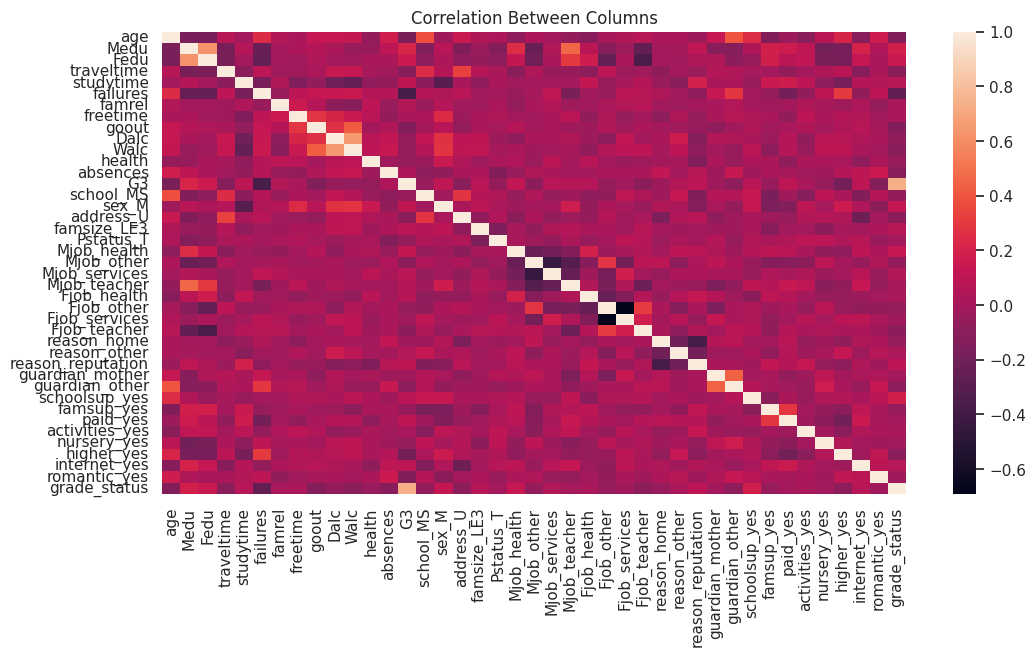

In [20]:
#@title correlation plot
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(corr_matrix,
           xticklabels=corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values,
            ax = ax,
           ).set_title("Correlation Between Columns")


plt.show()

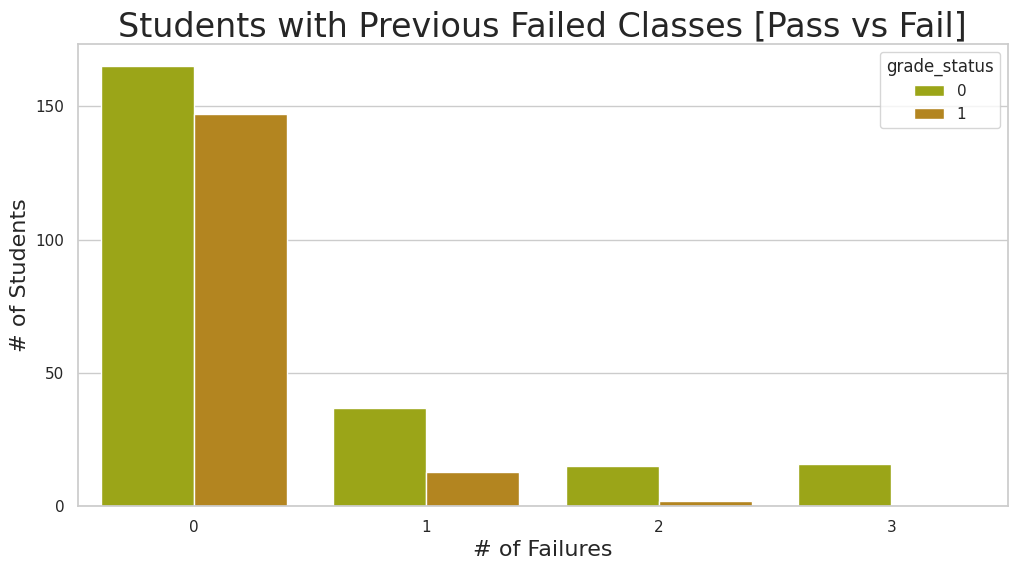

In [21]:
#@title student previous failures related to grade status (pass or fail)

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
colors = ["#AFBC01", "#CB8E08"]
g = sns.countplot(x="failures", hue="grade_status", palette=colors, data=df)
sns.set(style="darkgrid")
g.axes.set_title("Students with Previous Failed Classes [Pass vs Fail]",fontsize=24)
g.set_xlabel("# of Failures",fontsize=16)
g.set_ylabel("# of Students",fontsize=16)
sns.set(font_scale=3)
plt.show()

In [22]:
#@title previous failures related to pass/fail percentage

import pandas as pd
import plotly.express as px
import plotly.io as pio

# Ensure Plotly renders properly in the environment
pio.renderers.default = 'colab'  # For Google Colab

# Assuming df already has a 'grade_status' column with 0 (Fail) and 1 (Pass), and a 'failures' column

# Group the data by 'failures' and count the number of Passes (1) and Fails (0)
grouped_df = df.groupby('failures')['grade_status'].value_counts().unstack(fill_value=0).reset_index()

# Check the columns of the grouped_df to ensure they are correctly named
print("Grouped DataFrame Columns: ", grouped_df.columns)
print("Grouped DataFrame Head: ", grouped_df.head())

# Calculate the percentage of Pass (1) and Fail (0) for each number of previous failures
grouped_df['failed_percent'] = grouped_df[0] / (grouped_df[0] + grouped_df[1]) * 100
grouped_df['passed_percent'] = grouped_df[1] / (grouped_df[0] + grouped_df[1]) * 100

# Melt the DataFrame to have a single column for the percentage values and another column for Pass/Fail
melted_df = grouped_df.melt(id_vars=['failures'], value_vars=['failed_percent', 'passed_percent'],
                            var_name='status', value_name='percentage')

# Check the melted DataFrame
print("Melted DataFrame Head: ", melted_df.head())

# Create a grouped bar chart using Plotly Express
fig = px.bar(melted_df, x='failures', y='percentage', color='status',
             barmode='group',
             labels={'percentage': 'Percentage', 'failures': 'Number of Previous Failures'},
             color_discrete_sequence=['#FA5858', '#BEF781'],
             title='% of People with Failures who passed the Course')

# Force the plot to render
fig.show()


Grouped DataFrame Columns:  Index(['failures', 0, 1], dtype='object', name='grade_status')
Grouped DataFrame Head:  grade_status  failures    0    1
0                    0  165  147
1                    1   37   13
2                    2   15    2
3                    3   16    0
Melted DataFrame Head:     failures          status  percentage
0         0  failed_percent   52.884615
1         1  failed_percent   74.000000
2         2  failed_percent   88.235294
3         3  failed_percent  100.000000
4         0  passed_percent   47.115385


# final visualizations

Final Partial Dependence Plot saved as final_partial_dependence_plot.png


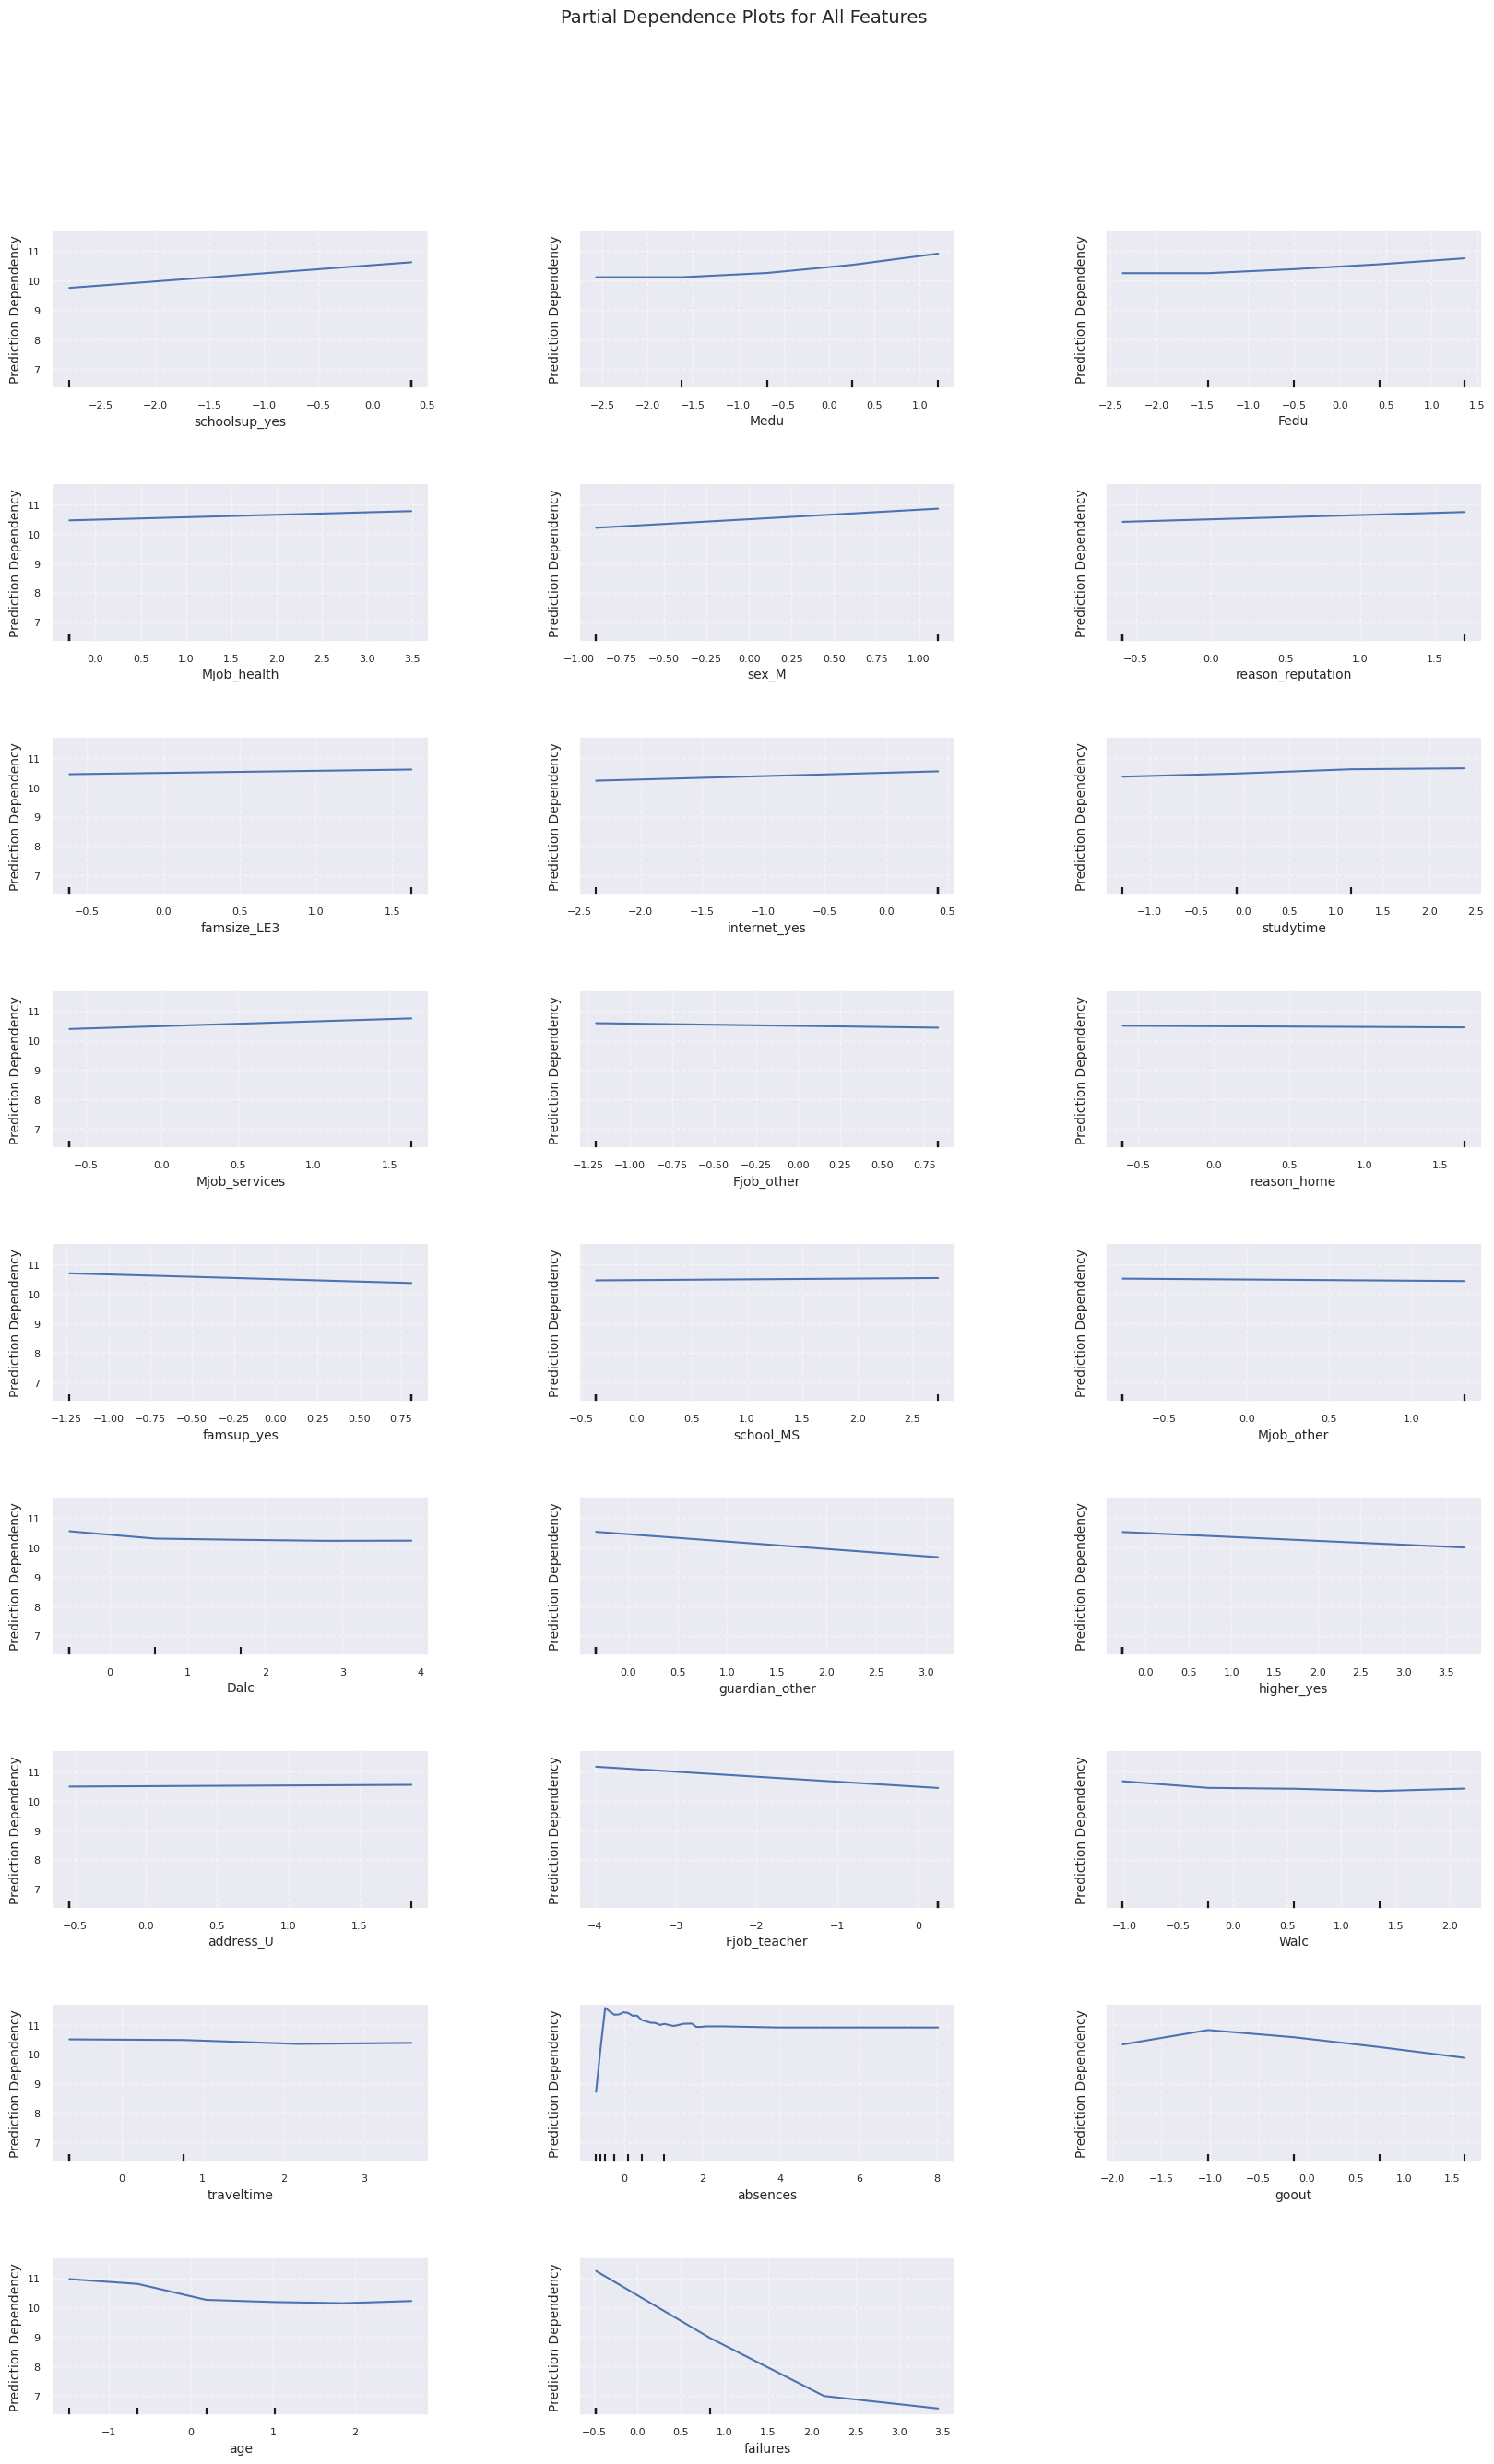

In [23]:
#@title partial dependence plot

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Ensure the correct feature names are used
scaled_feature_names = X.columns.tolist()

# Define all features for PDP
features_pdp = ['schoolsup_yes', 'Medu', 'Fedu', 'Mjob_health', 'sex_M',
                'reason_reputation', 'famsize_LE3', 'internet_yes', 'studytime',
                'Mjob_services', 'Fjob_other', 'reason_home', 'famsup_yes', 'school_MS',
                'Mjob_other', 'Dalc', 'guardian_other', 'higher_yes', 'address_U',
                'Fjob_teacher', 'Walc', 'traveltime', 'absences', 'goout', 'age',
                'failures']

# Ensure features are valid
valid_features_pdp = [f for f in features_pdp if f in scaled_feature_names]

# Create the plot
fig, ax = plt.subplots(figsize=(20, 30))  # Increase figure size for clarity
pdp_display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_train_scaled,
    valid_features_pdp,
    feature_names=scaled_feature_names,
    ax=ax
)

# Add a main title with smaller, readable text
plt.suptitle("Partial Dependence Plots for All Features", fontsize=14, y=0.98)

# Iterate over subplots to ensure readability
for ax_ in pdp_display.axes_.ravel():
    if ax_ is not None:  # Only adjust non-empty axes
        ax_.set_ylabel("Prediction Dependency", fontsize=10)
        ax_.set_xlabel(ax_.get_xlabel(), fontsize=10)
        ax_.tick_params(axis="both", labelsize=8)  # Smaller tick labels
        ax_.grid(True, linestyle="--", alpha=0.5)  # Add light gridlines

# Adjust layout for proper spacing
plt.subplots_adjust(top=0.9, hspace=0.6, wspace=0.4)  # Fine-tune spacing

# Save the final plot
pdp_filename = "final_partial_dependence_plot.png"
plt.savefig(pdp_filename, bbox_inches="tight")  # Save without cropping
print(f"Final Partial Dependence Plot saved as {pdp_filename}")

plt.show()


Bee Swarm Plot saved as shap_bee_swarm_plot_corrected.png


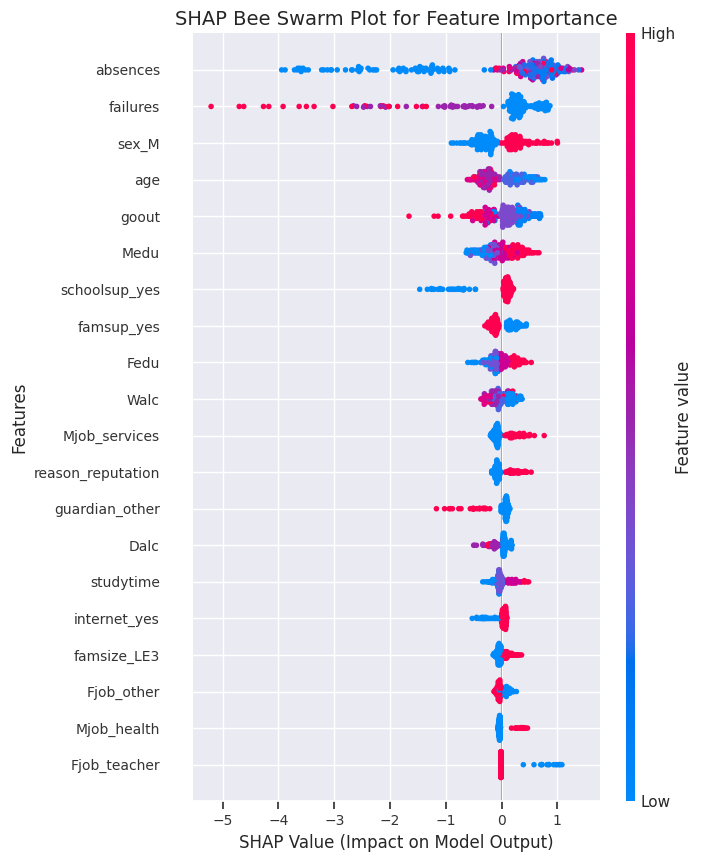

In [24]:
#@title bee swarm plot

import shap
import matplotlib.pyplot as plt

# Ensure SHAP explainer is set up
explainer = shap.Explainer(best_model, X_train_scaled)  # Initialize without check_additivity
shap_values = explainer(X_train_scaled, check_additivity=False)  # Disable additivity during computation

# Generate the Bee Swarm Plot
plt.figure(figsize=(16, 10))  # Set figure size for readability
shap.summary_plot(
    shap_values,
    X_train_scaled,
    feature_names=X.columns,
    plot_type="dot",  # Bee swarm plot type
    show=False  # Suppress immediate display for adjustments
)

# Add a title and adjust font sizes
plt.title("SHAP Bee Swarm Plot for Feature Importance", fontsize=14)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the Bee Swarm Plot
bee_swarm_filename = "shap_bee_swarm_plot_corrected.png"
plt.savefig(bee_swarm_filename, bbox_inches="tight")  # Save without cropping
print(f"Bee Swarm Plot saved as {bee_swarm_filename}")

# Show the plot
plt.show()


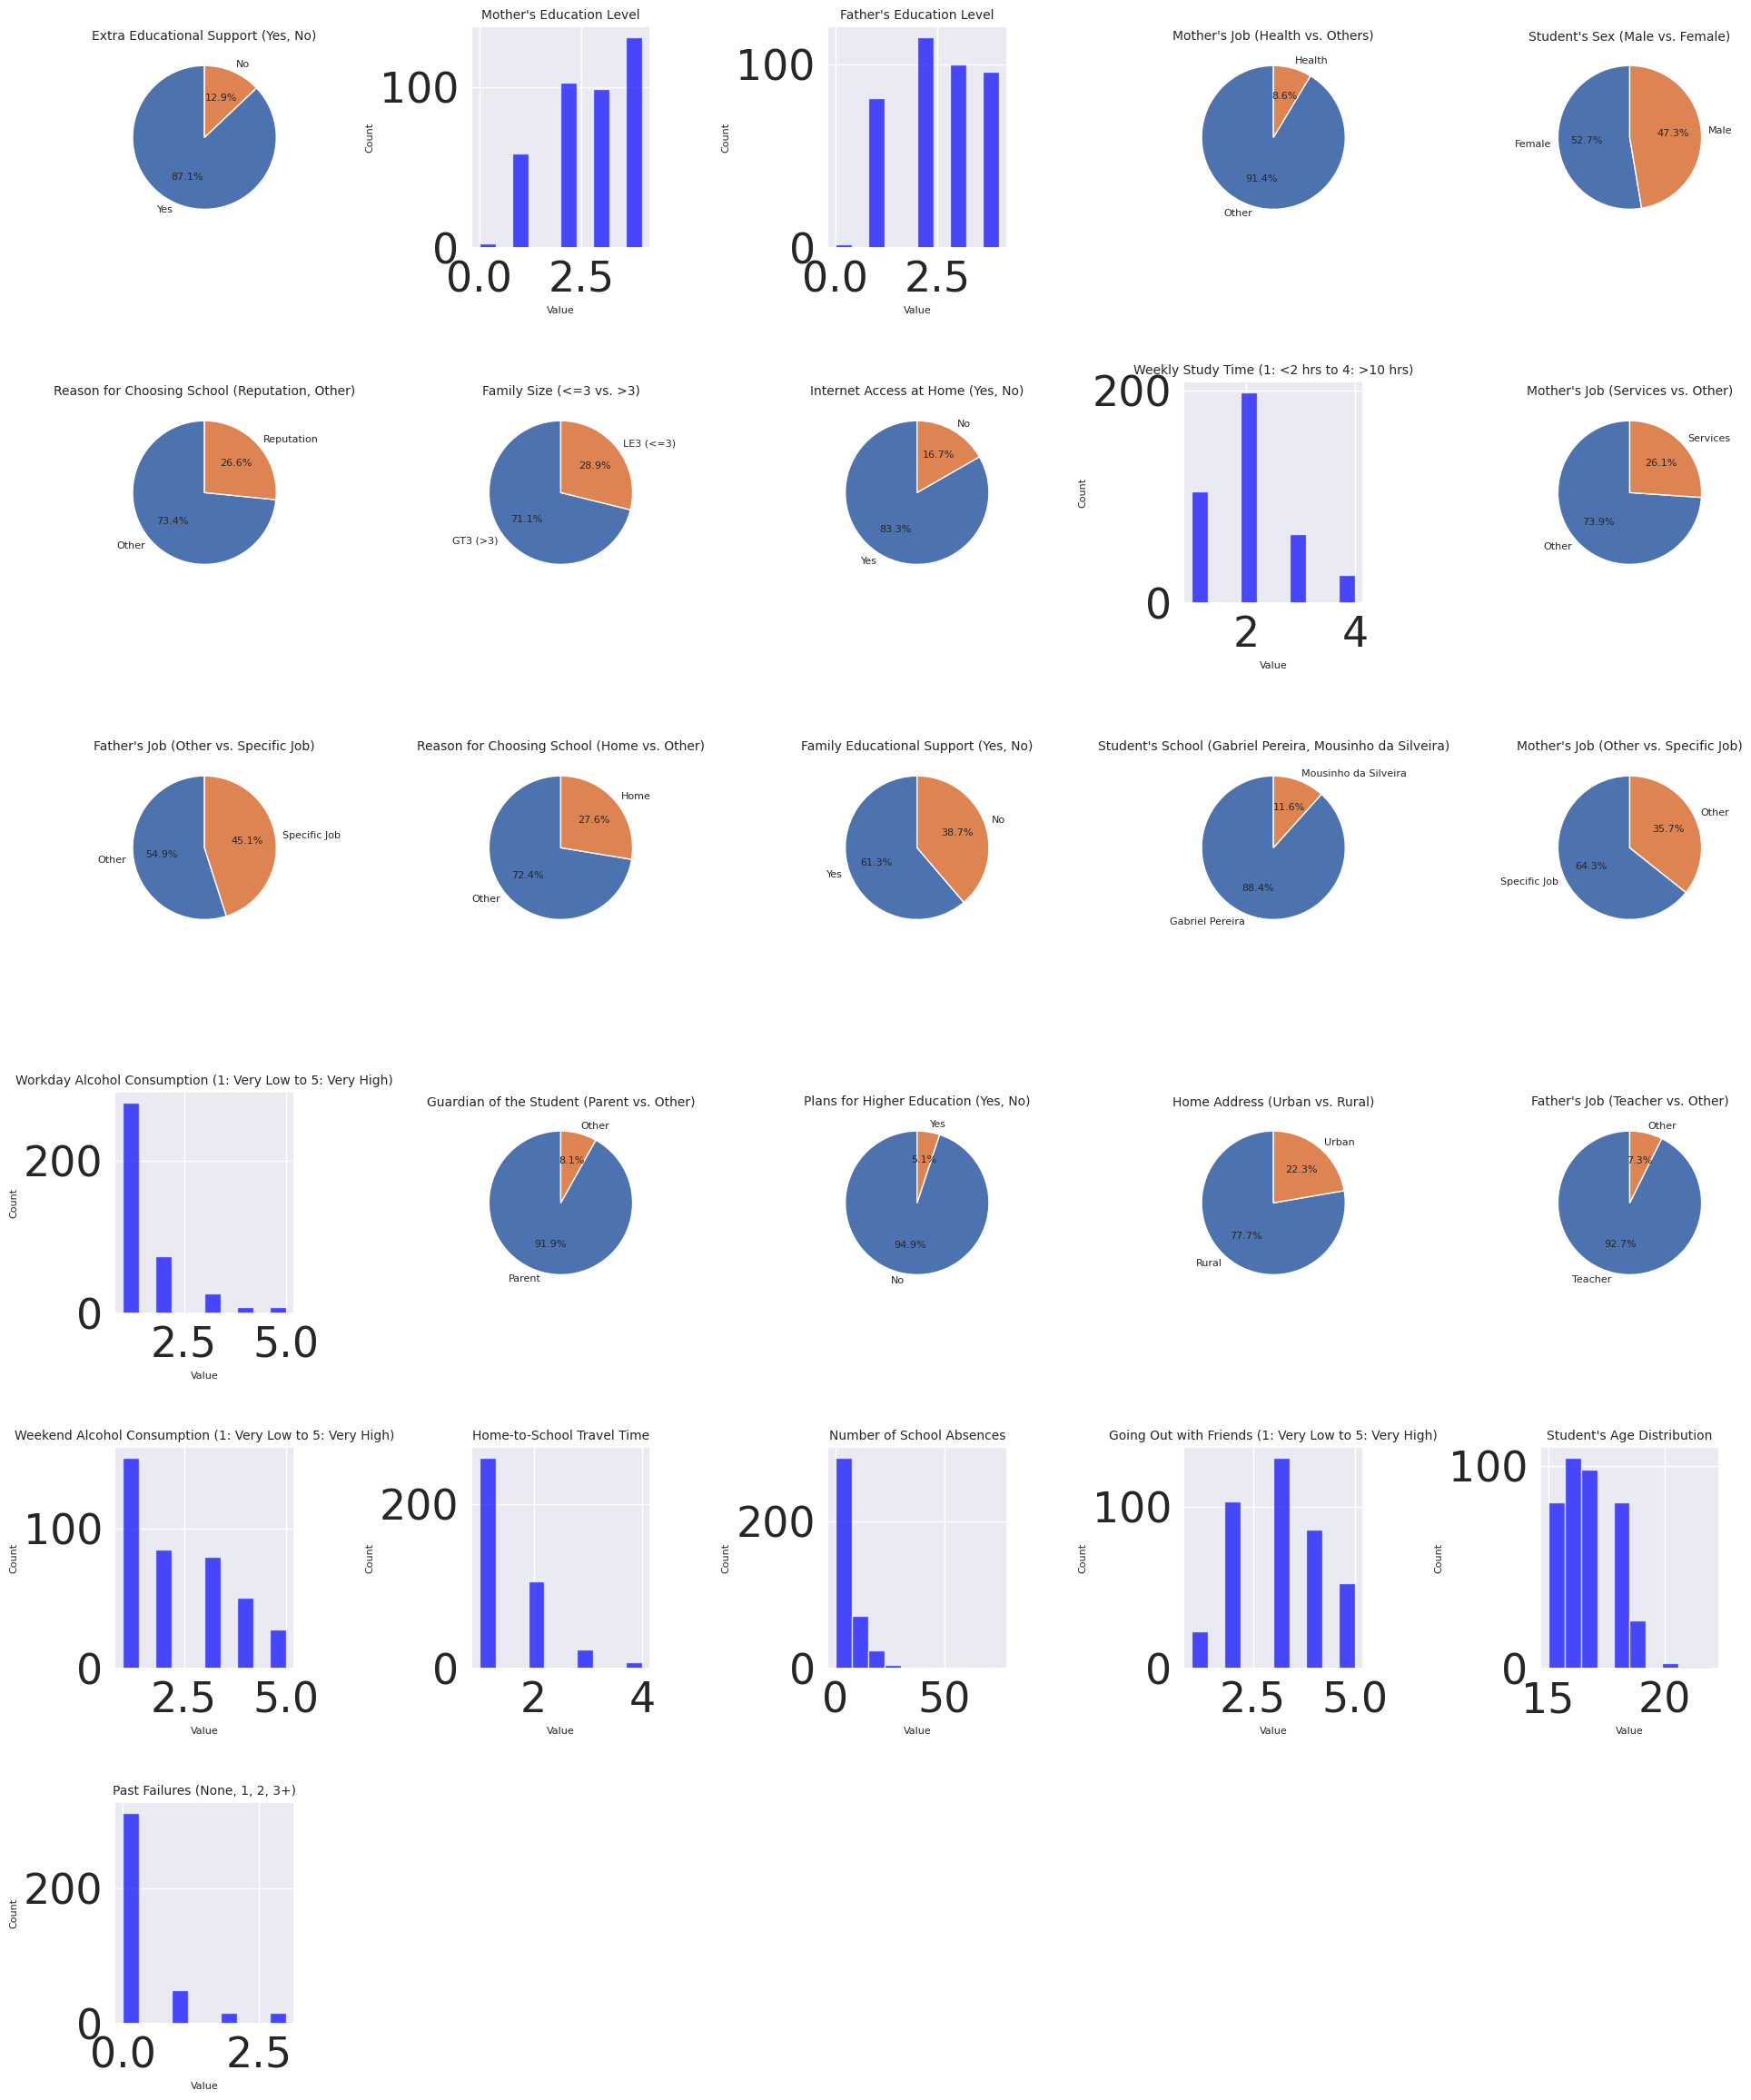

In [25]:
#@title feature distribution

import matplotlib.pyplot as plt
import pandas as pd

# Ensure proper mappings and relevant feature descriptions
feature_mappings = {
    # Categorical features with original mappings
    'school_MS': {0: 'Gabriel Pereira', 1: 'Mousinho da Silveira'},
    'sex_M': {0: 'Female', 1: 'Male'},
    'address_U': {0: 'Rural', 1: 'Urban'},
    'famsize_LE3': {0: 'GT3 (>3)', 1: 'LE3 (<=3)'},
    'Pstatus': {0: 'Apart', 1: 'Together'},
    'schoolsup_yes': {0: 'No', 1: 'Yes'},
    'famsup_yes': {0: 'No', 1: 'Yes'},
    'paid_yes': {0: 'No', 1: 'Yes'},
    'internet_yes': {0: 'No', 1: 'Yes'},
    'guardian_other': {0: 'Parent', 1: 'Other'},
    'reason_reputation': {0: 'Other', 1: 'Reputation'},
    'reason_home': {0: 'Other', 1: 'Home'},
    'Mjob_health': {0: 'Other', 1: 'Health'},
    'Mjob_other': {0: 'Specific Job', 1: 'Other'},
    'Mjob_services': {0: 'Other', 1: 'Services'},
    'Fjob_other': {0: 'Specific Job', 1: 'Other'},
    'Fjob_teacher': {0: 'Other', 1: 'Teacher'},
    'higher_yes': {0: 'No', 1: 'Yes'},
    # Numerical data will use a histogram or bar chart
}

feature_titles = {
    'schoolsup_yes': "Extra Educational Support (Yes, No)",
    'Medu': "Mother's Education Level",
    'Fedu': "Father's Education Level",
    'Mjob_health': "Mother's Job (Health vs. Others)",
    'sex_M': "Student's Sex (Male vs. Female)",
    'reason_reputation': "Reason for Choosing School (Reputation, Other)",
    'famsize_LE3': "Family Size (<=3 vs. >3)",
    'internet_yes': "Internet Access at Home (Yes, No)",
    'studytime': "Weekly Study Time (1: <2 hrs to 4: >10 hrs)",
    'Mjob_services': "Mother's Job (Services vs. Other)",
    'Fjob_other': "Father's Job (Other vs. Specific Job)",
    'reason_home': "Reason for Choosing School (Home vs. Other)",
    'famsup_yes': "Family Educational Support (Yes, No)",
    'school_MS': "Student's School (Gabriel Pereira, Mousinho da Silveira)",
    'Mjob_other': "Mother's Job (Other vs. Specific Job)",
    'Dalc': "Workday Alcohol Consumption (1: Very Low to 5: Very High)",
    'guardian_other': "Guardian of the Student (Parent vs. Other)",
    'higher_yes': "Plans for Higher Education (Yes, No)",
    'address_U': "Home Address (Urban vs. Rural)",
    'Fjob_teacher': "Father's Job (Teacher vs. Other)",
    'Walc': "Weekend Alcohol Consumption (1: Very Low to 5: Very High)",
    'traveltime': "Home-to-School Travel Time",
    'absences': "Number of School Absences",
    'goout': "Going Out with Friends (1: Very Low to 5: Very High)",
    'age': "Student's Age Distribution",
    'failures': "Past Failures (None, 1, 2, 3+)",
}

# Plotting function
def plot_features(df, feature_mappings, feature_titles):
    fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # Adjust grid size based on features
    axes = axes.flatten()

    for i, (col, title) in enumerate(feature_titles.items()):
        if col not in df.columns:
            axes[i].axis('off')
            continue

        # Use pie chart for categorical features
        if col in feature_mappings:
            mapping = feature_mappings[col]
            counts = df[col].map(mapping).value_counts()
            axes[i].pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                textprops={'fontsize': 8}
            )
            axes[i].set_title(title, fontsize=10)

        # Use histogram for numerical features
        elif pd.api.types.is_numeric_dtype(df[col]):
            axes[i].hist(df[col], bins=10, color='blue', alpha=0.7)
            axes[i].set_title(title, fontsize=10)
            axes[i].set_xlabel("Value", fontsize=8)
            axes[i].set_ylabel("Count", fontsize=8)

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig("improved_feature_plots.png", dpi=300)
    plt.show()

# Call the function to plot all features
plot_features(df, feature_mappings, feature_titles)
